# IMDb data set results

In [ ]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import torch

sys.path.append("../../")
from experiments.datasets import IMDBLoader
from experiments.architectures.image_transforms import create_image_transform, create_image_encoder
from experiments.architectures.vector_transforms import create_vector_transform
from manifold_flow.flows import ManifoldFlow, EncoderManifoldFlow, Flow
import plot_settings as ps


In [ ]:
ps.setup()

## Helper function to go from torch to numpy conventions

In [3]:
def trf(x):
    return np.clip(np.transpose(x, [1,2,0]) / 256., 0., 1.)

## Load models

In [4]:
def load_af_model(
    filename,
    layers=28,
    levels=4,
    splinebins=11,
    splinerange=10.0,
    dropout=0.0,
    actnorm=True,
    batchnorm=False,
):
    steps_per_level = layers // levels
    spline_params = {
        "apply_unconditional_transform": False,
        "min_bin_height": 0.001,
        "min_bin_width": 0.001,
        "min_derivative": 0.001,
        "num_bins": splinebins,
        "tail_bound": splinerange,
    }
    transform = create_image_transform(
        3,
        64,
        64,
        levels=levels,
        hidden_channels=100,
        steps_per_level=steps_per_level,
        num_res_blocks=2,
        alpha=0.05,
        num_bits=8,
        preprocessing="glow",
        dropout_prob=dropout,
        multi_scale=True,
        spline_params=spline_params,
        use_batchnorm=batchnorm,
        use_actnorm=actnorm,
        postprocessing="permutation",
        context_features=1,
    )
    model = Flow(data_dim=(3, 64, 64), transform=transform)
        
    model.load_state_dict(
        torch.load("../data/models/{}.pt".format(filename), map_location=torch.device("cpu"))
    )
    _ = model.eval()
    
    return model

In [5]:
def load_mf_model(
    filename,
    outerlayers=20,
    innerlayers=8,
    levels=4,
    splinebins=11,
    splinerange=10.0,
    dropout=0.0,
    actnorm=True,
    batchnorm=False,
    linlayers=2,
    linchannelfactor=2,
    lineartransform="lu"
):
    steps_per_level = outerlayers // levels
    spline_params = {
        "apply_unconditional_transform": False,
        "min_bin_height": 0.001,
        "min_bin_width": 0.001,
        "min_derivative": 0.001,
        "num_bins": splinebins,
        "tail_bound": splinerange,
    }
    outer_transform = create_image_transform(
        3,
        64,
        64,
        levels=levels,
        hidden_channels=100,
        steps_per_level=steps_per_level,
        num_res_blocks=2,
        alpha=0.05,
        num_bits=8,
        preprocessing="glow",
        dropout_prob=dropout,
        multi_scale=True,
        spline_params=spline_params,
        postprocessing="partial_mlp",
        postprocessing_layers=linlayers,
        postprocessing_channel_factor=linchannelfactor,
        use_actnorm=actnorm,
        use_batchnorm=batchnorm,
    )
    inner_transform = create_vector_transform(
        512,
        innerlayers,
        linear_transform_type=lineartransform,
        base_transform_type="rq-coupling",
        context_features=1,
        dropout_probability=dropout,
        tail_bound=splinerange,
        num_bins=splinebins,
        use_batch_norm=batchnorm,
    )
    model = ManifoldFlow(
        data_dim=(3, 64, 64),
        latent_dim=512,
        outer_transform=outer_transform,
        inner_transform=inner_transform,
        apply_context_to_outer=False,
        pie_epsilon=0.1,
        clip_pie=None
    )
        
    model.load_state_dict(
        torch.load("../data/models/{}.pt".format(filename), map_location=torch.device("cpu"))
    )
    _ = model.eval()
    
    return model

In [6]:
def load_emf_model(
    filename,
    outerlayers=20,
    innerlayers=8,
    levels=4,
    splinebins=11,
    splinerange=10.0,
    dropout=0.0,
    actnorm=True,
    batchnorm=False,
    linlayers=2,
    linchannelfactor=2,
    lineartransform="lu"
):
    steps_per_level = outerlayers // levels
    spline_params = {
        "apply_unconditional_transform": False,
        "min_bin_height": 0.001,
        "min_bin_width": 0.001,
        "min_derivative": 0.001,
        "num_bins": splinebins,
        "tail_bound": splinerange,
    }
    encoder = create_image_encoder(
        3,
        64,
        64,
        latent_dim=512,
        context_features=None,
    )
    outer_transform = create_image_transform(
        3,
        64,
        64,
        levels=levels,
        hidden_channels=100,
        steps_per_level=steps_per_level,
        num_res_blocks=2,
        alpha=0.05,
        num_bits=8,
        preprocessing="glow",
        dropout_prob=dropout,
        multi_scale=True,
        spline_params=spline_params,
        postprocessing="partial_mlp",
        postprocessing_layers=linlayers,
        postprocessing_channel_factor=linchannelfactor,
        use_actnorm=actnorm,
        use_batchnorm=batchnorm,
    )
    inner_transform = create_vector_transform(
        512,
        innerlayers,
        linear_transform_type=lineartransform,
        base_transform_type="rq-coupling",
        context_features=1,
        dropout_probability=dropout,
        tail_bound=splinerange,
        num_bins=splinebins,
        use_batch_norm=batchnorm,
    )
    model = EncoderManifoldFlow(
        data_dim=(3, 64, 64),
        latent_dim=512,
        encoder=encoder,
        outer_transform=outer_transform,
        inner_transform=inner_transform,
        apply_context_to_outer=False,
        pie_epsilon=0.1,
        clip_pie=None
    )
        
    model.load_state_dict(
        torch.load("../data/models/{}.pt".format(filename), map_location=torch.device("cpu"))
    )
    _ = model.eval()
    
    return model

In [7]:
af = load_af_model("flow_512_imdb_april_run10")
emf = load_emf_model("emf_512_imdb_april_run10")

/Users/distiller/project/conda/conda-bld/pytorch_1587428061935/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


## Evaluate test images

In [44]:
sim = IMDBLoader()

loader = sim.load_dataset(train=False, dataset_dir="../data/samples/imdb")
test_idx=list(range(20, 28))
n_test = len(test_idx)

x_test = np.array([loader[i][0].numpy() for i in test_idx])
param_true = [sim.preprocess_params(loader[i][1], inverse=True) for i in test_idx]

n_grid = 13
param_grid = np.linspace(18., 80., n_grid)


In [45]:
x_test_ = torch.tensor(x_test).to(torch.float)
param_grid_ = torch.tensor(sim.preprocess_params(param_grid)).unsqueeze(1).to(torch.float)

logp_af = [af(x.unsqueeze(0).expand(n_grid, -1, -1, -1), context=param_grid_)[1].detach().numpy() for x in x_test_]
logp_emf = [emf(x.unsqueeze(0).expand(n_grid, -1, -1, -1), context=param_grid_, mode="mf-fixed-manifold")[1].detach().numpy() for x in x_test_]


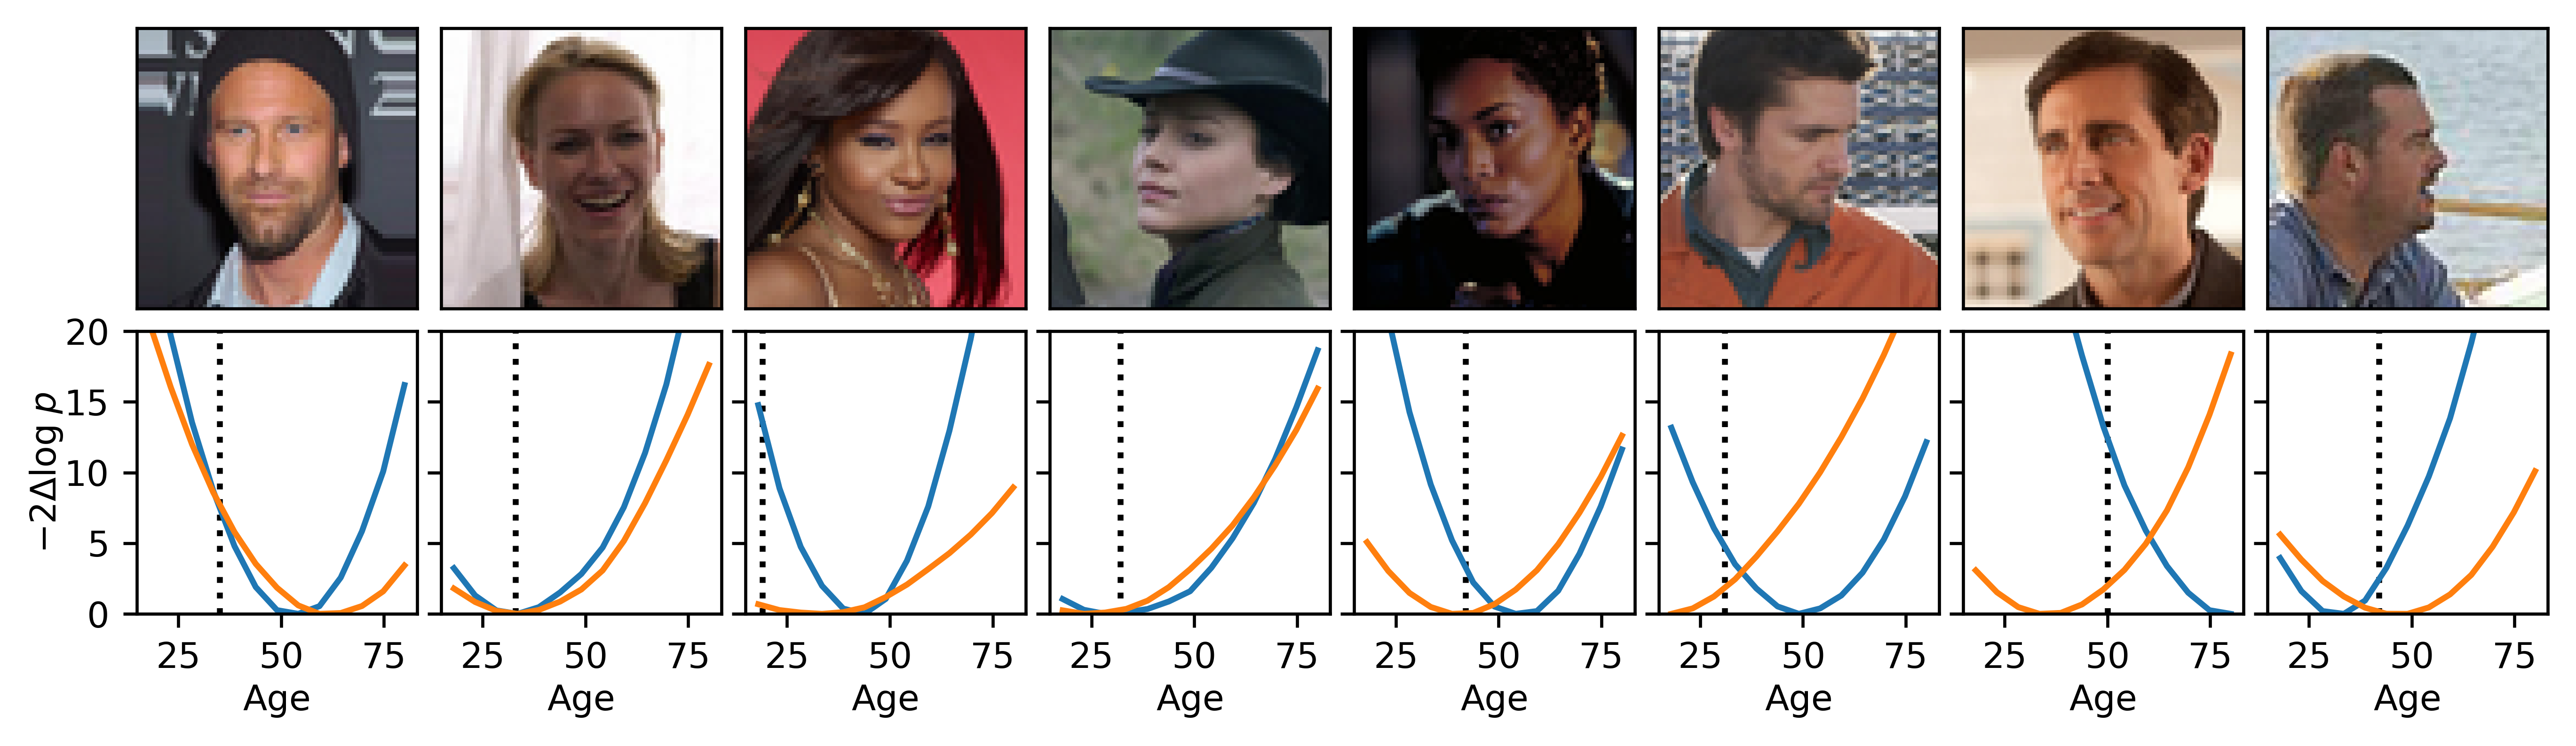

In [46]:
fig, gs = ps.grid_width(n_test, 2, width=ps.TEXTWIDTH, large_margin=0.15, small_margin=0.03, sep=0.03)

for i in range(n_test):
    # Test image
    ax = plt.subplot(gs[i])
    plt.imshow(trf(x_test[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Log likelihood vs age
    ax = plt.subplot(gs[n_test + i])
    plt.plot([param_true[i], param_true[i]], [0., 100.], c="black", ls=":", label="True age")
    for y, label in zip([logp_af[i], logp_emf[i]], ["AF", r"$\mathcal{M}_e$-flow"]):
        plt.plot(param_grid, -2.*(y - np.max(y)), label=label)
        
    if i == 0:
        # plt.legend()
        plt.ylabel(r"$-2 \Delta \log \; p$", labelpad=0)
        
    plt.ylim(0., 20.)
    plt.yticks([0.,5.,10.,15.,20.], labels=None if i == 0 else [])
    plt.xlabel("Age", labelpad=2)

plt.savefig("../figures/imdb_age_inference.pdf")
